# HW2: Model Explanability

## 1. Load data for modeling.  This data represents taxi rides in NY (from a Kaggle competition)

In [5]:
import math
import scipy
import warnings
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import xgboost as xgb
import matplotlib.pylab as plt
import pyarrow

from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

matplotlib.use('nbagg');
warnings.filterwarnings("ignore");
%matplotlib inline

In [6]:
# Download the data (public github)
!wget -N https://github.com/rfox12-edu/explainability-sandbox/raw/main/x_train.parquet.gzip
!wget -N https://github.com/rfox12-edu/explainability-sandbox/raw/main/x_test.parquet.gzip
!wget -N https://github.com/rfox12-edu/explainability-sandbox/raw/main/y_train.parquet.gzip
!wget -N https://github.com/rfox12-edu/explainability-sandbox/raw/main/y_test.parquet.gzip

zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget
zsh:1: command not found: wget


In [7]:
# Load the data into pandas dataframes
x_train = pd.read_parquet('x_train.parquet.gzip')
x_test = pd.read_parquet('x_test.parquet.gzip')
y_train = pd.read_parquet('y_train.parquet.gzip')
y_test = pd.read_parquet('y_test.parquet.gzip')

## 2. Model Build

### Random Forest Regression

In [8]:
regr_rf = RandomForestRegressor(max_features='sqrt', min_samples_leaf = 4,
    min_samples_split = 3, n_estimators = 40, n_jobs = -1)
regr_rf.fit(x_train, y_train)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [9]:
y_train_pred_rf = regr_rf.predict(x_train)
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)

y_pred_rf = regr_rf.predict(x_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)

print('Train MSE:' , mse_train_rf)
print('Test MSE: ', mse_rf)

Train MSE: 82.97168937331173
Test MSE:  165.9206643352234


### XGboost Regression

In [10]:
regr_xgb = xgb.XGBRegressor(
    learning_rate=0.1, n_estimators=1000, max_depth=3, min_child_weight=3,
    gamma=0, subsample=0.8, reg_alpha=200, reg_lambda=200, colsample_bytree=0.8, n_jobs=-1
)
regr_xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [11]:
# Predicting on train & test data using our trained XgBoost regressor model
y_train_pred_xgb = regr_xgb.predict(x_train)
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)

y_pred_xgb = regr_xgb.predict(x_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)

print('Train MSE:' ,mse_train_xgb)
print('Test MSE: ', mse_xgb)

Train MSE: 158.24951524443995
Test MSE:  168.18855740911232


### Feed forward NN: MLP

In [12]:
regr_mlp = MLPRegressor(
        hidden_layer_sizes=[50, 25],
        activation='relu',
        solver='adam',
        early_stopping=True,
        random_state=33
)
regr_mlp.fit(x_train, y_train)

MLPRegressor(early_stopping=True, hidden_layer_sizes=[50, 25], random_state=33)

In [13]:
y_train_pred_mlp = regr_mlp.predict(x_train)
mse_train_mlp = mean_squared_error(y_train, y_train_pred_mlp)

y_pred_mlp = regr_mlp.predict(x_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)

print('Train MSE:' , mse_train_mlp)
print('Test MSE: ', mse_mlp)

Train MSE: 166.36158474862745
Test MSE:  163.90548439517627


### Q1 (5pts): Which model is the most over-fit to its training data?

- #### Random Forest among the models has the biggest difference so it is overfitting.

### Q2 (5pts): Is AUC an appropriate metric to evaluate these models?  Why or why not?

- ### No AUC is primarily used in multiclass/binary classification models compared to these regression models. The goal is to divide multiple classes compared to predicting outcomes that can be continuous.

# Global Explanability

## Random Forest Feature Importance

### Q3 (5pts): Why is it important to look the overall predictive power of a model before looking at feature importance for that model?

- ### Poor predictive power reflects how a model perfoms on unseen data and can indicate a model is lacking or flawed in some way, making the feature importance less accurate in their interpetation.

### Q4 (5pts): How could you validate that these regression models are providing any predictive power at all? [you do not have to write code to answer this question]

- ### Validation can be very helpful by checking that it is making meaningful prediction and not overfitting/underfitting our data. Using Train-Test Split is one method to assess how generalized our model is while another is K-fold validation.

In [14]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ':  FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [15]:
def permutation_based_feature_importance(x_test, y_test, initial_mse, model):

    # Initialize an array to store feature importances
    feature_importances = np.zeros(x_test.shape[1])

    # Number of permutation iterations (you can adjust this value)
    num_iterations = 100

    # Calculate feature importance by permuting one feature at a time
    ####################### CODE HERE ############################
    for feature in range(x_test.shape[1]):
        print('Permuting feature ',feature + 1)
        # Copy the original test data
        x_test_permuted = x_test.copy()

        # Shuffle the values of the current feature
        permuted_column = x_test_permuted.iloc[:, feature]
        np.random.shuffle(permuted_column)
        x_test_permuted.iloc[:, feature] = permuted_column

        # Calculate the accuracy with the permuted feature
        permuted_mse = mean_squared_error(y_test, model.predict(x_test_permuted))

        # Calculate the drop in accuracy and store it as feature importance
        feature_importances[feature] = initial_mse - permuted_mse

    # Normalize the feature importances
    feature_importances /= feature_importances.sum()

    # Get the names of the features (assuming X is a DataFrame)
    feature_names = x_test.columns

    # Sort features by importance
    sorted_idx = np.argsort(feature_importances)

    return feature_importances[sorted_idx]

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

def permutation_based_feature_importance(x_test, y_test, initial_mse, model):

    # Initialize an array to store feature importances
    feature_importances = np.zeros(x_test.shape[1])

    # Number of permutation iterations (you can adjust this value)
    num_iterations = 100

    # Calculate feature importance by permuting one feature at a time
    for feature in range(x_test.shape[1]):
        print('Permuting feature', feature + 1)
        
        # Copy the original test data
        x_test_permuted = x_test.copy()

        # Shuffle the values of the current feature
        permuted_column = x_test_permuted.iloc[:, feature].values
        np.random.shuffle(permuted_column)
        x_test_permuted.iloc[:, feature] = permuted_column

        # Calculate the MSE with the permuted feature
        permuted_mse = mean_squared_error(y_test, model.predict(x_test_permuted))

        # Calculate the change in MSE and store it as feature importance
        feature_importances[feature] = permuted_mse - initial_mse

    # Normalize the feature importances
    feature_importances /= np.sum(feature_importances)

    # Get the names of the features (assuming X is a DataFrame)
    feature_names = x_test.columns

    # Sort features by importance in descending order
    sorted_idx = np.argsort(-feature_importances)

    # Return the sorted feature importances and corresponding feature names
    return feature_importances[sorted_idx], feature_names[sorted_idx]


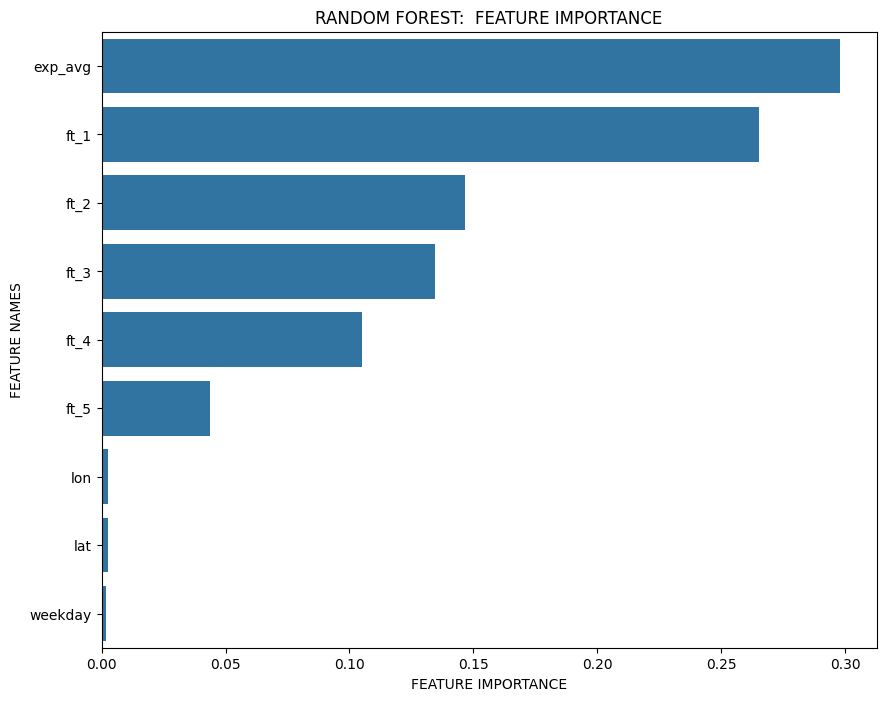

In [16]:
plot_feature_importance(regr_rf.feature_importances_,x_train.columns,'RANDOM FOREST')

In [17]:
permutation_based_feature_importance_rf = permutation_based_feature_importance(x_train, y_train, mse_train_rf, regr_rf)

Permuting feature  1
Permuting feature  2
Permuting feature  3
Permuting feature  4
Permuting feature  5
Permuting feature  6
Permuting feature  7
Permuting feature  8
Permuting feature  9


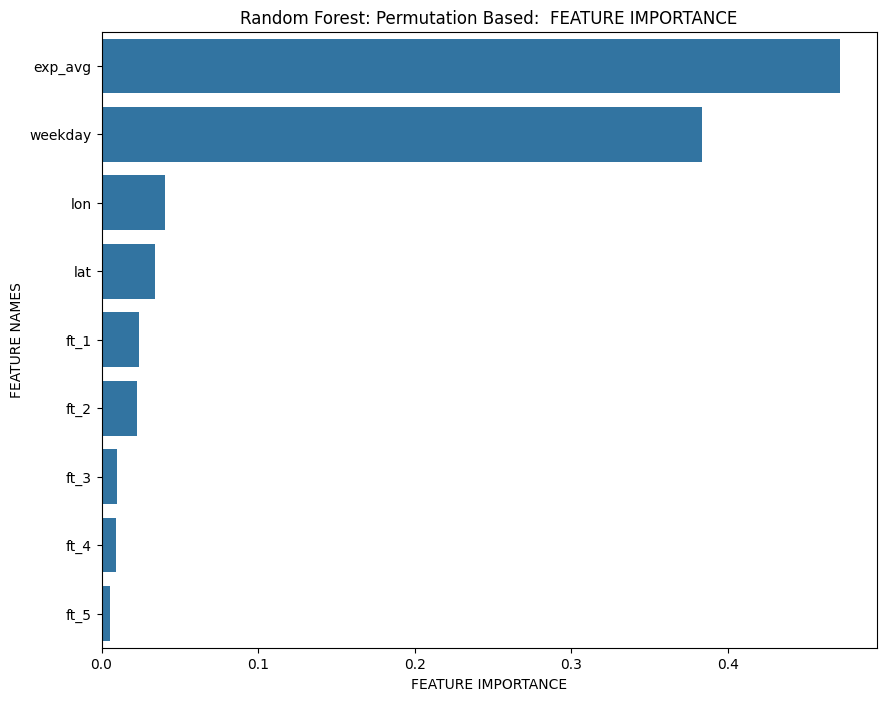

In [18]:
plot_feature_importance(permutation_based_feature_importance_rf,x_train.columns,'Random Forest: Permutation Based')

### Q5 (5pts): Is the `weekday` feature important to the `regr_rf` model?

- ### In a normal gini importance model, it has little importance but when permutated (measures the decrease in model performance when a feature's values are randomly shuffle), it plays a large part in the feature importance. Weekday in this regard, is important to the underlying features different from nomral methods.

### Q6 (5pts): Is the `weekday` feature important to predicting the target?

- ### I think it is important, this is supported by the permutated feature importance as it tends to give a more reliable measure of each features predictive power. It being the second highest indicates that the model needs weekday for its predictive capabilities.

### Q7 (10pts): Is the `.feature_importances_` of the `regr_rf` model reliable?  Why or why not?  [hint](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)

- ### It is not always more reliable as the feature_importances_ method is based on the gini impurity or mean decrease impurity. Can inflate the importance of high-cardinality features and those that appear more frequently in the training data and suffer overfitting if computed on training data.

### Q8 (5pts): Are there any highly correlated features in this dataset?  Which ones?

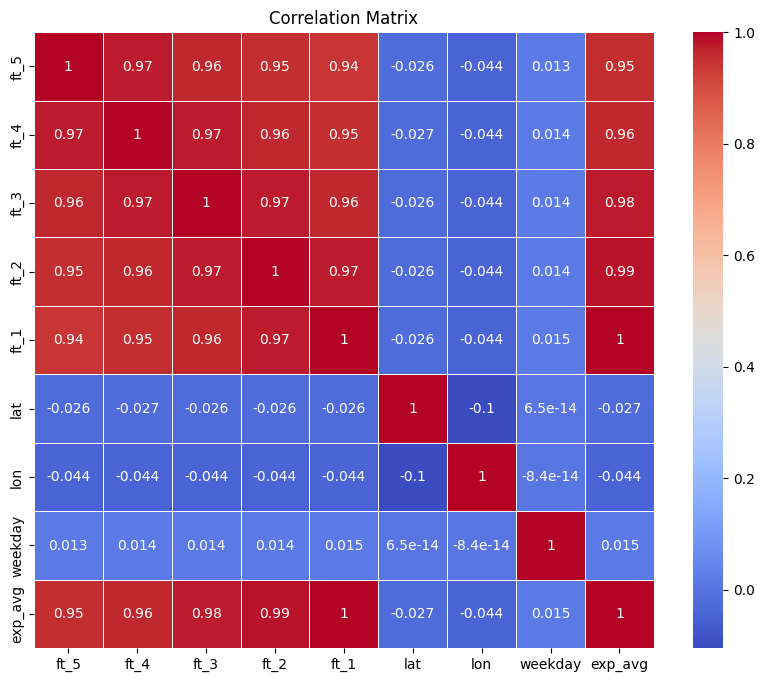

In [19]:
# Calculate the correlation matrix
corr_matrix = x_train.corr()

# Plotting the heatmap
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

### Q9 (5pts): What is the impact of highly correlated features on the analysis of feature importance for these models?

## Random Forest Feature Analysis

In [20]:
from sklearn.inspection import PartialDependenceDisplay

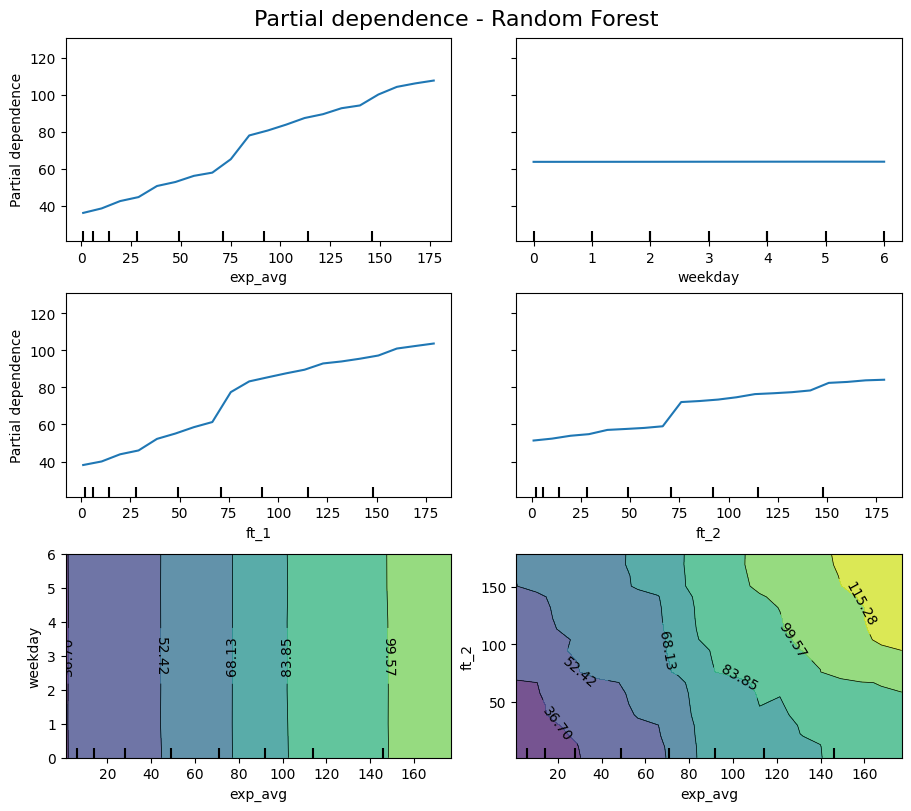

In [21]:
common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    # features of interest
    "features": ["exp_avg", 'weekday', 'ft_1', 'ft_2', ("exp_avg", 'weekday'), ("exp_avg", 'ft_2')],
    # type of partial dependence plot
    "kind": "average"
}

_, ax = plt.subplots(ncols=2, nrows=3, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    regr_rf,
    x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(("Partial dependence - Random Forest"),fontsize=16)

### Q8 (5pts): Explain the partial dependence plot of 'exp_avg'.

- ### exp_avg has a upward trend, indicating that as 'exp_avg' increases, the predicted response (target variable) also increases. It has some steeper increases at certain intervals, which may suggest thresholds or points where changes in 'exp_avg' have a more significant impact on the predicted outcome. Clearly it is an important feature influencing the model's prediction. A rise in 'exp_avg' pushes the prediction higher.

### Q9 (10pts): Is there any interaction between 'exp_avg' and 'weekday'? How about 'exp_avg' and 'ft_2'?


In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
explainer_rf = shap.Explainer(regr_rf, x_train)

In [ ]:
shap_values_rf = explainer_rf(x_test[0:1000])

In [ ]:
shap.summary_plot(shap_values_rf, x_test[0:1000])

### Q10 (5pts): Is `weekday` showing as an important factor on prediction explanations via SHAP?


## XGBoost Feature Importance

In [ ]:
plot_feature_importance(regr_xgb.feature_importances_,x_train.columns,'XGBoost')

In [ ]:
permutation_based_feature_importance_xgb = permutation_based_feature_importance(x_train, y_train, mse_train_xgb, regr_xgb)

plot_feature_importance(permutation_based_feature_importance_xgb,x_train.columns,'XGBoost: Permutation Based')

### Q11 (10pts): Based on the permutation-method feature importance chart for the XGBoost model, would you recommend that the model take out the less influential variables ft_1, ft_2, ft_3, ft_4, and ft_5 ?  Why or why not?


## XGBoost Feature Analysis

In [ ]:
_, ax = plt.subplots(ncols=2, nrows=3, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    regr_xgb,
    x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(("Partial dependence - XGBoost"),fontsize=16)

In [ ]:
explainer_xgb = shap.Explainer(regr_xgb, x_train)
shap_values_xgb = explainer_xgb(x_test[0:100])

In [ ]:
shap.summary_plot(shap_values_xgb, x_test[0:100])

## MLP Feature Importance

In [ ]:
permutation_based_feature_importance_mlp = permutation_based_feature_importance(x_train, y_train, mse_train_mlp, regr_mlp)

plot_feature_importance(permutation_based_feature_importance_mlp,x_train.columns,'MLP: Permutation Based')

## MLP Feature Analysis

In [ ]:
_, ax = plt.subplots(ncols=2, nrows=3, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    regr_mlp,
    x_train,
    **features_info,
    ax=ax,
    **common_params,
)

_ = display.figure_.suptitle(("Partial dependence - MLP"),fontsize=16)

In [ ]:
# for NN, we use 'KernelExplainer', but it's very very slow. So we use 'shap.sample' to sample a subset.
n_samples = 100
explainer_mlp = shap.KernelExplainer(regr_mlp.predict, shap.sample(x_train, n_samples))

In [ ]:
shap_values_mlp = explainer_mlp(x_test[0:100])

In [ ]:
shap.summary_plot(shap_values_mlp, x_test[0:100])

# Local Explainability

## Random Forest SHAP

In [ ]:
x_test[:1]

In [ ]:
print('Actual:', y_test['target'].iloc[0], 'Random Forest:', y_pred_rf[:1], 'XGBoost:', y_pred_xgb[:1], 'MLP:', y_pred_mlp[:1])

In [ ]:
shap.plots.waterfall(shap_values_rf[0])

In [ ]:
shap.plots.bar(shap_values_rf[0])

### Q12 (5pts): What is the difference between the plots shown by `shap.plots.waterfall` and `shap.plots.bar`?

In [ ]:
shap.plots.waterfall(shap_values_xgb[0])

In [ ]:
shap.plots.waterfall(shap_values_mlp[0])

### Q13 (5pts): How is it possible that two models (like the XGBoost and MLP models above) can have very similar permutation feature importance but very different SHAP explanations for the same data point?

In [ ]:
test_prediction = x_test[0:1].assign(lon=-95.369804,lat=29.760427)
test_prediction

In [ ]:
shap_values_test = explainer_xgb(test_prediction)
shap.plots.waterfall(shap_values_test[0])

### Q14 (5pts): Are feature effects independent from each other in our SHAP XGBoost explainer?

### Q15 (5pts): `lon=-95.369804,lat=29.760427` is Houston, TX.  What would a data scientist need to do to create good explanations for this region?